# PCO2 Histogram

`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
import scipy

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

## Area

In [4]:
variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

dd_A = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

# combine datasets just to pick first member and it gets naming the way i want
dd_A = combine_datasets(
    dd_A,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_A.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['GFDL-ESM4.gr.historical.Ofx']

### New coords with `dd` and `dd_x`

`A` is area over Pacific and southern ocean. They get `newcoords`


In [6]:
A = dd_A['GFDL-ESM4.gr.historical.Ofx'].isel(x=slice(180,200), y = slice(-80,-30)).areacello
# # A2 = dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello
# # A


# newcoords = {'x':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['x'], 'y':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}
newcoords = {'x':A['x'], 'y':A['y']}
newcoords

{'x': <xarray.DataArray 'x' (x: 20)>
 array([180.5, 181.5, 182.5, 183.5, 184.5, 185.5, 186.5, 187.5, 188.5, 189.5,
        190.5, 191.5, 192.5, 193.5, 194.5, 195.5, 196.5, 197.5, 198.5, 199.5])
 Coordinates:
   * x        (x) float64 180.5 181.5 182.5 183.5 ... 196.5 197.5 198.5 199.5
 Attributes:
     axis:           X
     bounds:         lon_bnds
     cell_methods:   time: point
     long_name:      longitude
     standard_name:  longitude
     units:          degrees_E,
 'y': <xarray.DataArray 'y' (y: 50)>
 array([10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5,
        34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5, 44.5, 45.5,
        46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5,
        58.5, 59.5])
 Coordinates:
   * y        (y) float64 10.5 11.5 12.5 13.5 14.5 ... 55.5 56.5 57.5 58.5 59.5
 Attributes:
     axis:           Y
     bounds: 

## Get datasets and calculate variables

### These datasets are selected over Pacific, southern ocean, and upper 1000m
I load them, reassign their coords to match `dd_A['GFDL-ESM4.gr.historical.Ofx']`, and then calculate `p`, `insitutemp`, `sigma2`, and `sigma0`, '`PCO2`

In [7]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc').isel(x=slice(180,200), lev = slice(0, 1000), y = slice(-80,-30))
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc').isel(x=slice(180,200), lev = slice(0, 1000), y = slice(-80,-30))
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc').isel(x=slice(180,200), lev = slice(0, 1000), y = slice(-80,-30))
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc').isel(x=slice(180,200), lev = slice(0, 1000), y = slice(-80,-30))
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc').isel(x=slice(180,200), lev = slice(0, 1000), y = slice(-80,-30))
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc').isel(x=slice(180,200), lev = slice(0, 1000), y = slice(-80,-30))
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc').isel(x=slice(180,200), lev = slice(0, 1000), y = slice(-80,-30))
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc').isel(x=slice(180,200), lev = slice(0, 1000), y = slice(-80,-30))
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc').isel(x=slice(180,200), lev = slice(0, 1000), y = slice(-80,-30))
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc').isel(x=slice(180,200), lev = slice(0, 1000), y = slice(-80,-30))
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc').isel(x=slice(180,200), lev = slice(0, 1000), y = slice(-80,-30))
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc').isel(x=slice(180,200), lev = slice(0, 1000), y = slice(-80,-30))
# A = xr.open_mfdataset('AREA.nc')

In [8]:
for name, ds in dd.items():
    dd[name] = ds.assign_coords(**newcoords)

In [9]:
for name, ds in dd.items():
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])

In [10]:
for name, ds in dd.items():
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
                        temperature = ds['insitutemp'])
    # ds['PCO2'] = results['pCO2_out']
    # ppco2 = ds.dissic.copy(data=results['pCO2_out'])
    ds['PCO2'] = ds.dissic.copy(data=results['pCO2_out'])



In [11]:
dd['CESM2-FV2.gr.historical.Omon']


<xarray.Dataset>
Dimensions:     (y: 50, x: 20, lev: 33)
Coordinates:
  * y           (y) float64 10.5 11.5 12.5 13.5 14.5 ... 56.5 57.5 58.5 59.5
  * x           (x) float64 180.5 181.5 182.5 183.5 ... 196.5 197.5 198.5 199.5
    lon         (x, y) float64 dask.array<chunksize=(20, 50), meta=np.ndarray>
    lat         (x, y) float64 dask.array<chunksize=(20, 50), meta=np.ndarray>
  * lev         (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Data variables:
    dissic      (lev, y, x) float32 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    fgco2       (y, x) float32 dask.array<chunksize=(50, 20), meta=np.ndarray>
    so          (lev, y, x) float32 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    talk        (lev, y, x) float32 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    thetao      (lev, y, x) float32 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    p           (lev, y, x) float64 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    insitutemp  (lev, y, x) float64 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    sigma2      (lev, y, x) float64 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    sigma0      (lev, y, x) float64 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    PCO2        (lev, y, x) float64 287.2 287.4 287.7 287.9 ... nan nan nan nan

## Lev Bounds

I'm going to gloss over all of the methods here, but all this next section does is get `lev_bounds` because I didn't save those locally

In [12]:
variables = ['dissic']
#              ,'talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


dd_gn = merge_variables(dd_gn)
# # list(dd_new.keys())

temp={}
for name,item in dd_gn.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gn = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gn = combine_datasets(
    dd_gn,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gn.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [13]:
variables = ['dissic']
#              ,'talk', 'so', 'thetao', 'fgco2']
# 'areacello', 
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4',
                         'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gr = merge_variables(dd_gr)


temp={}
for name,item in dd_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gr = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['CESM2-WACCM.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon']

In [14]:
dd_lev = {**dd_gr, **dd_gn}
list(dd_lev.keys())

['CESM2-WACCM.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [15]:
dd_lev['CESM2-FV2.gr.historical.Omon']

<xarray.Dataset>
Dimensions:        (time: 1980, lev: 33, y: 180, x: 360, bnds: 2, vertex: 4)
Coordinates:
  * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev            (lev) float64 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time           (time) object 1850-01-15 13:00:00 ... 2014-12-15 12:00:00
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(180, 2, 360), meta=np.ndarray>
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(33, 2), meta=np.ndarray>
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 180), meta=np.ndarray>
    time_bounds    (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lon            (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat            (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lon_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    lat_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
Dimensions without coordinates: bnds, vertex
Data variables:
    dissic         (time, lev, y, x) float32 dask.array<chunksize=(5, 33, 180, 360), meta=np.ndarray>
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    674885.0
    branch_time_in_parent:   10950.0
    case_id:                 1561
    ...                      ...
    variant_info:            CMIP6 CESM2-FV2 historical experiment (1850-2014...
    variant_label:           r3i1p1f1
    netcdf_tracking_ids:     hdl:21.14100/9f22e540-8143-4b04-aabc-7c86a911fa2...
    version_id:              v20200226
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.NCAR.CESM2-FV2.historical.r3i1p1f1.Omon.dis...

In [17]:
for name, ds in dd.items():
    ds['lev_bounds'] = dd_lev[name].isel(x=slice(180,200), lev = slice(0, 1000), y = slice(-80,-30)).lev_bounds

In [18]:
dd['CESM2-FV2.gr.historical.Omon']

<xarray.Dataset>
Dimensions:     (y: 50, x: 20, lev: 33, bnds: 2)
Coordinates:
  * y           (y) float64 10.5 11.5 12.5 13.5 14.5 ... 56.5 57.5 58.5 59.5
  * x           (x) float64 180.5 181.5 182.5 183.5 ... 196.5 197.5 198.5 199.5
    lon         (x, y) float64 dask.array<chunksize=(20, 50), meta=np.ndarray>
    lat         (x, y) float64 dask.array<chunksize=(20, 50), meta=np.ndarray>
  * lev         (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Dimensions without coordinates: bnds
Data variables:
    dissic      (lev, y, x) float32 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    fgco2       (y, x) float32 dask.array<chunksize=(50, 20), meta=np.ndarray>
    so          (lev, y, x) float32 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    talk        (lev, y, x) float32 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    thetao      (lev, y, x) float32 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    p           (lev, y, x) float64 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    insitutemp  (lev, y, x) float64 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    sigma2      (lev, y, x) float64 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    sigma0      (lev, y, x) float64 dask.array<chunksize=(33, 50, 20), meta=np.ndarray>
    PCO2        (lev, y, x) float64 287.2 287.4 287.7 287.9 ... nan nan nan nan
    lev_bounds  (lev, bnds) float64 dask.array<chunksize=(33, 2), meta=np.ndarray>

## Get volume


In [20]:
V = {}

for name, ds in dd.items():
    V[name] = A * ds.lev_bounds


## Calculate `PCO2` * volume & `sigma0`; then average over `x`
> Volume is in `V` dictionary

>`PCO2` and `sigma0` are in `dd` dictionary. They are selected over Pacific `x` range, Southern Ocean `y` range, and upper 1000m but they are not yet averaged

In [48]:
PCO2_V = {}

for name, ds in dd.items():
    PCO2_V[name] = {}
    da = PCO2_V[name]
    ppco2 = V[name]*ds.PCO2
    # da['PCO2'] = ds.PCO2.mean(['x'],keep_attrs=True)
    da['PCO2'] = ppco2.mean(['x'],keep_attrs=True)
    da['sigma0'] = ds.sigma0.mean(['x'],keep_attrs=True)
    da['vol'] = V[name].mean(['x'],keep_attrs=True)


## Histogram for plot colors

In [35]:
model_kwargs = {}
model_kwargs['UKESM1-0-LL.gn.historical.Omon'] = {'color': '#8f5904'}
model_kwargs['CanESM5-CanOE.gn.historical.Omon'] = {'color': '#a1a1a1'}
model_kwargs['CNRM-ESM2-1.gn.historical.Omon'] = {'color': '#cc0000'}
model_kwargs['CanESM5.gn.historical.Omon'] = {'color': '#ff8200'}
model_kwargs['IPSL-CM6A-LR.gn.historical.Omon'] = {'color': '#f1c232'}
model_kwargs['CESM2-WACCM.gr.historical.Omon'] = {'color': '#8fce00'}
model_kwargs['CESM2.gr.historical.Omon'] = {'color': '#20b2aa'}
model_kwargs['CESM2-WACCM-FV2.gr.historical.Omon'] = {'color': '#66ccff'}
model_kwargs['GFDL-ESM4.gr.historical.Omon'] = {'color': '#674ea7'}
model_kwargs['GFDL-CM4.gr.historical.Omon'] = {'color': '#800080'}
model_kwargs['MRI-ESM2-0.gr.historical.Omon'] = {'color': '#ff80ed'}
model_kwargs['CESM2-FV2.gr.historical.Omon'] = {'color': '#024c8f'}

## Volume weighted histogram for PCO2


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWa

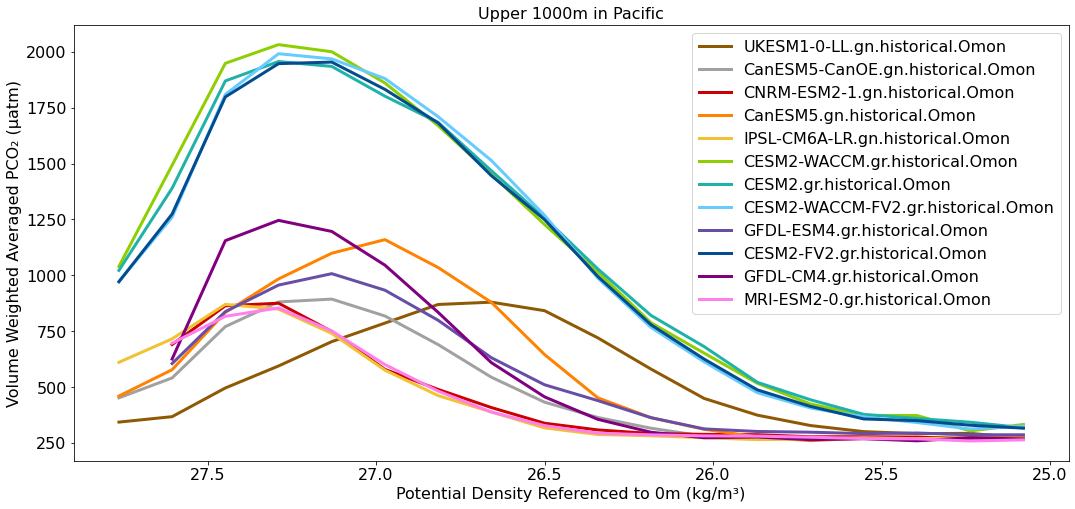

In [58]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[16,8])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 16)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

target = np.linspace(25, 28, 20)
binz = np.linspace(25, 28, 20)

conversion = 3.1536e7 * 83.3
ax_idx = 0
# for name, ds in dd.items():
for name, ds in PCO2_V.items():

    h2 = histogram(ds['sigma0'], bins = [binz], weights = ds['PCO2'])
    h3 = histogram(ds['sigma0'], bins = [binz], weights = ds['vol'])
    hi = h2/h3
    hi.plot(label = name, lw = 3, **model_kwargs[name])
    
ax.invert_xaxis()
#     ax.set_title(name)
    # ax_idx += 1
ax.set_xlabel('Potential Density Referenced to 0m (kg/m\u00b3)', fontsize = 16)
ax.set_ylabel('Volume Weighted Averaged PCO\u2082 (\u03BCatm)', fontsize = 16)
ax.set_title('Upper 1000m in Pacific')
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)

### This plot feels not right

I think the magnitude of volume weighted PCO2 might be too big and it's wacky that the volume weighted PCO2 values in the CESM2 models are bigger than in the CNRM model

## Tried again but instead of dividing histogram that is (PCO2 * Vol).mean(['x'],keep_attrs=True) by (volume).mean(['x'],keep_attrs=True) histogram, I did a histogram of (PCO2 * Vol).mean(['x'],keep_attrs=True) divided by (volume).mean(['x'],keep_attrs=True)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWa

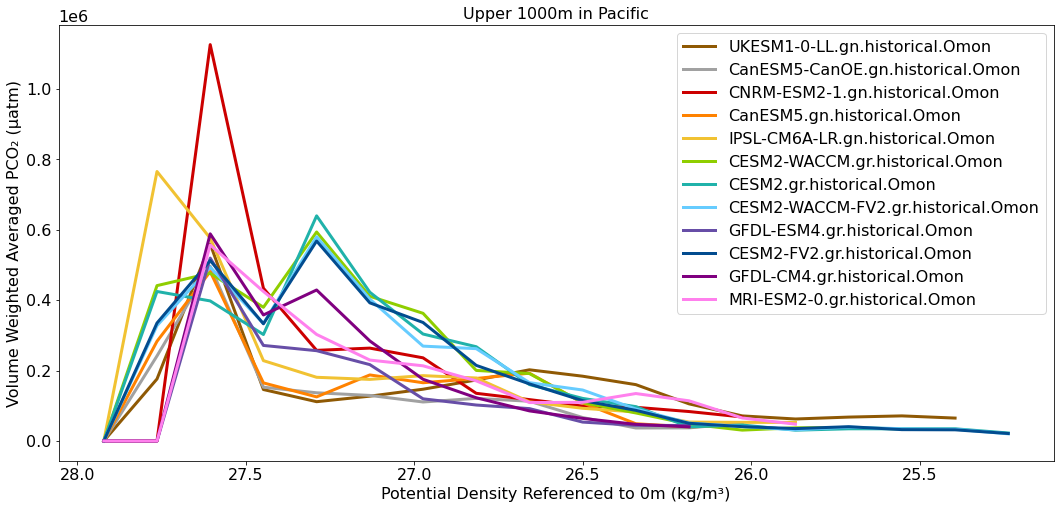

In [59]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[16,8])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 16)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

target = np.linspace(25, 28, 20)
binz = np.linspace(25, 28, 20)

conversion = 3.1536e7 * 83.3
ax_idx = 0
# for name, ds in dd.items():
for name, ds in PCO2_V.items():

    h2 = histogram(ds['sigma0'], bins = [binz], weights = ds['PCO2']/ds['vol'])
    # h3 = histogram(ds['sigma0'], bins = [binz], weights = ds['vol'])
    # hi = h2/h3
    h2.plot(label = name, lw = 3, **model_kwargs[name])
    
ax.invert_xaxis()
#     ax.set_title(name)
    # ax_idx += 1
ax.set_xlabel('Potential Density Referenced to 0m (kg/m\u00b3)', fontsize = 16)
ax.set_ylabel('Volume Weighted Averaged PCO\u2082 (\u03BCatm)', fontsize = 16)
ax.set_title('Upper 1000m in Pacific')
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)

### This feels closer to right because at least CNRM is the biggest
but UKEMS1 is greater than CanESM5 and CanESM5-CanOE

Magnitude might also be too big. Truly I am unsure